# Load data

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


In [2]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Training dataset creation (if not yet created)

### Input data: filtered SGS heat flux

In [3]:
Qstar = xr.open_dataset(
    "gs://leap-persistent/panalluri/HF_star.zarr", engine="zarr", chunks={}
)
Qstar

<xarray.Dataset> Size: 14GB
Dimensions:   (time: 365, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 14GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>

### Choose same regions as Abigail

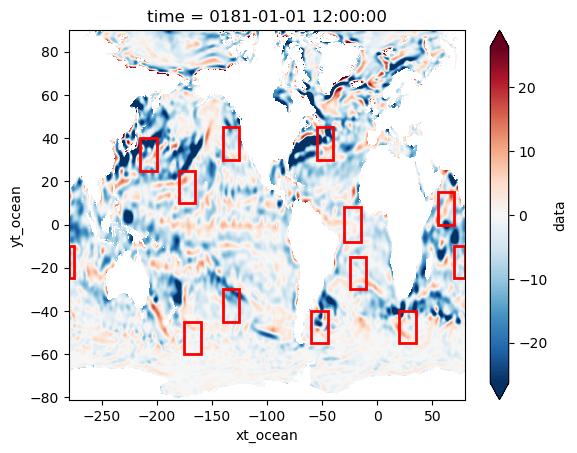

In [4]:
import matplotlib.pyplot as plt

# Example plot with Qstar.data
Qstar.data.isel(time=0).plot(robust=True)

# Define multiple latitude and longitude ranges
# (conversion to ds coords by hand for now)
boxes = [
    (30, 45, -40, -55),  # gulf stream = (30, 45, -60, -45)
    (-30, -15, -25, -10),  # south atlantic = (-30, -15, -25, -10)
    (-8, 8, -30, -15), # equator atlantic = (-8, 8, -30, -15)    
    (-55, -40, -60, -45), # malvinas current = (-55, -40, -60, -45)
    (30, 45, -140, -125), # california current = (30, 45, -140, -125)
    (-45, -30, -140, -125), # south pacific = (-45, -30, -140, -125)
    (25, 40, -215, -200), # kuroshio extension = (25, 40, 145, 160)
    (10, 25, -180, -165), # north pacific = (10, 25, -180, -165)
    (-60, -45, -175, -160), # southern ocean, new zealand = (-60, -45, -175, -160)
    (-55, -40, 20, 35), # agulhas current = (-55, -40, 20, 35)
    (-25, -10, 70, 79.95), # indian ocean (west chunk) = (-25, -10, 70, 85)
    (-25, -10, -279.95, -275), # indian ocean (east chunk) = (-25, -10, 70, 85)
    (0, 15, 55, 70) # arabian sea = (0, 15, 55, 70)
]

for lat_min, lat_max, lon_min, lon_max in boxes:

    # Draw the box on the plot
    plt.gca().add_patch(
        plt.Rectangle(
            (lon_min, lat_min),  # (x, y) start point
            lon_max - lon_min,  # width
            lat_max - lat_min,  # height
            fill=False,          # don't fill the box
            edgecolor='red',     # color of the box
            linewidth=2
        )
    )

# Show the plot
plt.show()


### Construct Q_star input and output data set for each region

In [13]:
# data samples of regions in the ocean
# choose just one region
ds_Qstar_temp = Qstar.sel(yt_ocean=slice(-30, -15), xt_ocean=slice(-25, -10)) # South Atlantic
ds_Qstar = ds_Qstar_temp.isel(time=slice(0,365))
ds_Qstar # high res SGS heat flux

<xarray.Dataset> Size: 36MB
Dimensions:   (time: 365, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>

In [14]:
print("Filtering model")
Q_out = filter_inputs_dataset(ds_Qstar, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
Q_out # low res filtered heat flux

Filtering model


<xarray.Dataset> Size: 36MB
Dimensions:   (time: 365, xt_ocean: 150, yt_ocean: 163)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

### Construct input data: u_rel, v_rel, q_ref, t_ref, sst

u_rel = relative u_dir velocity b/n ocean and atmos \
v_rel = relative v_dir velocity b/n ocean and atmos \
q_ref = specific humidity at 2m in atmos \
t_ref = temperature at 2m in atmos \
sst = sea surface temp

In [17]:
ds_in = ds_merged.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

print("Filtering model")
ds_temp = ds_in.isel(time=slice(0,365))
ds_out = filter_inputs_dataset(ds_temp, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')

ds_lowRes = ds_out.sel(yt_ocean=slice(-30, -15), xt_ocean=slice(-25, -10)) # South Atlantic
ds_lowRes

Filtering model


<xarray.Dataset> Size: 393MB
Dimensions:       (time: 365, xt_ocean: 150, yt_ocean: 163)
Coordinates:
  * time          (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean      (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 36MB dask.array<chunksize=(3, 163, 150), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

### Organize training/testing data into batches

#### Timing steps in data processing

#### Set up parallel processing

In [47]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=2) #default: n_workers=4, threads_per_worker=1
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/8787/status,
Dashboard: /user/panalluri/proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36155,Workers: 4
Dashboard: /user/panalluri/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:40085,Total threads: 2
Dashboard: /user/panalluri/proxy/38181/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:38875,


2024-09-30 19:40:24,328 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='leap.2i2c.cloud', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/tornado/websocket.py", line 938, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/tornado/web.py", line 3301, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/srv/conda/envs/notebook/lib/python3.12/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


### Data processing

In [48]:
# Set number of time samples
time_training = ds_lowRes['time'][::30][:-4]
time_len = len(time_training)

# Define the dimensions
xt_len = len(ds_lowRes.xt_ocean) 
yt_len = len(ds_lowRes.yt_ocean) 

# Extract needed data
urel_data = ds_lowRes.u_relative.sel(time=time_training).values
vrel_data = ds_lowRes.v_relative.sel(time=time_training).values
sst_data = ds_lowRes.surface_temp.sel(time=time_training).values
tref_data = ds_lowRes.t_ref.sel(time=time_training).values
qref_data = ds_lowRes.q_ref.sel(time=time_training).values
Qstar_data = ds_Qstar.data.sel(time=time_training).values
Qout_data = Q_out.data.sel(time=time_training).values

# Define coordinates
xt_ocean = ds_lowRes.xt_ocean
yt_ocean = ds_lowRes.yt_ocean

# Preallocate the Dataset
ds_training = xr.Dataset(
    {
        'u_rel': (['time', 'yt_ocean', 'xt_ocean'], urel_data),  # Preallocated NaN array
        'v_rel': (['time', 'yt_ocean', 'xt_ocean'], vrel_data),      
        't_ref': (['time', 'yt_ocean', 'xt_ocean'], tref_data),
        'q_ref': (['time', 'yt_ocean', 'xt_ocean'], qref_data),
        'sst': (['time', 'yt_ocean', 'xt_ocean'], sst_data),
        'Q_star': (['time', 'yt_ocean', 'xt_ocean'], Qstar_data),
        'Q_out': (['time', 'yt_ocean', 'xt_ocean'], Qout_data)
    },
    coords={
        'time': time_training,
        'xt_ocean': xt_ocean,
        'yt_ocean': yt_ocean
    }
)

ds_training

<xarray.Dataset> Size: 11MB
Dimensions:   (time: 9, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 72B 0181-01-01 12:00:00 ... 0181-08-29 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    u_rel     (time, yt_ocean, xt_ocean) float64 2MB -0.9651 -1.036 ... -7.107
    v_rel     (time, yt_ocean, xt_ocean) float64 2MB -6.33 -6.322 ... 1.821
    t_ref     (time, yt_ocean, xt_ocean) float64 2MB 293.4 293.4 ... 291.3 291.3
    q_ref     (time, yt_ocean, xt_ocean) float64 2MB 0.01364 0.01363 ... 0.0102
    sst       (time, yt_ocean, xt_ocean) float64 2MB 293.3 293.3 ... 293.1 293.1
    Q_star    (time, yt_ocean, xt_ocean) float32 880kB 2.005 2.107 ... 0.6062
    Q_out     (time, yt_ocean, xt_ocean) float64 2MB -1.032 -0.9116 ... -2.053

In [49]:
# save to bucket
ds_training.to_zarr("gs://leap-persistent/panalluri/ds_trainingData_southAtlantic.zarr")

In [50]:
# Set number of time samples
time_testing = ds_lowRes['time'][::30][-4:]

# Create empty arrays (with NaNs) for preallocation
urel_data = ds_lowRes.u_relative.sel(time=time_testing).values
vrel_data = ds_lowRes.v_relative.sel(time=time_testing).values
sst_data = ds_lowRes.surface_temp.sel(time=time_testing).values
tref_data = ds_lowRes.t_ref.sel(time=time_testing).values
qref_data = ds_lowRes.q_ref.sel(time=time_testing).values
Qstar_data = ds_Qstar.data.sel(time=time_testing).values
Qout_data = Q_out.data.sel(time=time_testing).values

# Preallocate the Dataset
ds_testing = xr.Dataset(
    {
        'u_rel': (['time', 'yt_ocean', 'xt_ocean'], urel_data),  # Preallocated NaN array
        'v_rel': (['time', 'yt_ocean', 'xt_ocean'], vrel_data),      
        't_ref': (['time', 'yt_ocean', 'xt_ocean'], tref_data),
        'q_ref': (['time', 'yt_ocean', 'xt_ocean'], qref_data),
        'sst': (['time', 'yt_ocean', 'xt_ocean'], sst_data),
        'Q_star': (['time', 'yt_ocean', 'xt_ocean'], Qstar_data),
        'Q_out': (['time', 'yt_ocean', 'xt_ocean'], Qout_data)
    },
    coords={
        'time': time_testing,
        'xt_ocean': xt_ocean,
        'yt_ocean': yt_ocean
    }
)

ds_testing

<xarray.Dataset> Size: 5MB
Dimensions:   (time: 4, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 32B 0181-09-28 12:00:00 ... 0181-12-27 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    u_rel     (time, yt_ocean, xt_ocean) float64 782kB 0.09512 ... -6.891
    v_rel     (time, yt_ocean, xt_ocean) float64 782kB -2.708 -2.73 ... 4.335
    t_ref     (time, yt_ocean, xt_ocean) float64 782kB 288.6 288.6 ... 294.3
    q_ref     (time, yt_ocean, xt_ocean) float64 782kB 0.008611 ... 0.01347
    sst       (time, yt_ocean, xt_ocean) float64 782kB 289.9 289.9 ... 295.4
    Q_star    (time, yt_ocean, xt_ocean) float32 391kB -2.237 -2.368 ... -1.189
    Q_out     (time, yt_ocean, xt_ocean) float64 782kB -2.979 -3.049 ... 0.9041

In [53]:
# save to bucket
ds_testing.to_zarr("gs://leap-persistent/panalluri/ds_testingData_southAtlantic.zarr")

# Training/Testing Dataset Loading (if already created)

In [4]:
ds_training = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic.zarr", engine="zarr", chunks={}
) 
ds_training

<xarray.Dataset> Size: 11MB
Dimensions:   (time: 9, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 72B 0181-01-01 12:00:00 ... 0181-08-29 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    Q_out     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    Q_star    (time, yt_ocean, xt_ocean) float32 880kB dask.array<chunksize=(5, 82, 150), meta=np.ndarray>
    q_ref     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>

In [5]:
ds_testing = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_testingData_southAtlantic.zarr", engine="zarr", chunks={}
) 
ds_testing

<xarray.Dataset> Size: 5MB
Dimensions:   (time: 4, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 32B 0181-09-28 12:00:00 ... 0181-12-27 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    Q_out     (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>
    Q_star    (time, yt_ocean, xt_ocean) float32 391kB dask.array<chunksize=(2, 163, 150), meta=np.ndarray>
    q_ref     (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>

#### Convert to torch tensor

In [6]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = ds_training['u_rel'].values
v_rel = ds_training['v_rel'].values
t_ref = ds_training['t_ref'].values
q_ref = ds_training['q_ref'].values
sst = ds_training['sst'].values
Q_out = ds_training['Q_out'].values #Q_LR
Q_star = ds_training['Q_star'].values

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
training_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, t_ref, q_ref, sst, Q_out, Q_star], axis=3))

# Now data_array is a 4D tensor
training_NN_inputs


tensor([[[[-9.6512e-01, -6.3304e+00,  2.9336e+02,  ...,  2.9329e+02,
           -1.0321e+00,  2.0054e+00],
          [-1.0361e+00, -6.3221e+00,  2.9337e+02,  ...,  2.9329e+02,
           -9.1159e-01,  2.1065e+00],
          [-1.1081e+00, -6.3105e+00,  2.9337e+02,  ...,  2.9330e+02,
           -7.9348e-01,  2.2065e+00],
          ...,
          [-6.0987e+00,  1.2395e+00,  2.9200e+02,  ...,  2.9379e+02,
           -1.4039e+00, -1.1035e+01],
          [-6.1073e+00,  1.2843e+00,  2.9200e+02,  ...,  2.9378e+02,
           -1.2787e+00, -1.0932e+01],
          [-6.1152e+00,  1.3286e+00,  2.9199e+02,  ...,  2.9378e+02,
           -1.1546e+00, -1.0812e+01]],

         [[-9.2848e-01, -6.3078e+00,  2.9341e+02,  ...,  2.9335e+02,
           -9.5882e-01,  2.0596e+00],
          [-9.9952e-01, -6.2975e+00,  2.9341e+02,  ...,  2.9335e+02,
           -8.3501e-01,  2.1590e+00],
          [-1.0716e+00, -6.2841e+00,  2.9341e+02,  ...,  2.9335e+02,
           -7.1359e-01,  2.2578e+00],
          ...,
     

In [7]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = ds_testing['u_rel'].values
v_rel = ds_testing['v_rel'].values
t_ref = ds_testing['t_ref'].values
q_ref = ds_testing['q_ref'].values
sst = ds_testing['sst'].values
Q_out = ds_testing['Q_out'].values
Q_star = ds_testing['Q_star'].values

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
testing_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, t_ref, q_ref, sst, Q_out, Q_star], axis=3))

# Now data_array is a 4D tensor
testing_NN_inputs


tensor([[[[ 9.5125e-02, -2.7079e+00,  2.8859e+02,  ...,  2.8990e+02,
           -2.9795e+00, -2.2367e+00],
          [ 7.7923e-02, -2.7298e+00,  2.8857e+02,  ...,  2.8989e+02,
           -3.0489e+00, -2.3679e+00],
          [ 6.0952e-02, -2.7519e+00,  2.8855e+02,  ...,  2.8988e+02,
           -3.1185e+00, -2.5164e+00],
          ...,
          [-2.8880e+00,  9.1772e-02,  2.8700e+02,  ...,  2.8887e+02,
           -2.7768e+00, -2.1455e+00],
          [-2.9163e+00,  1.3600e-01,  2.8699e+02,  ...,  2.8886e+02,
           -2.8430e+00, -1.9782e+00],
          [-2.9451e+00,  1.7983e-01,  2.8698e+02,  ...,  2.8885e+02,
           -2.9108e+00, -1.8071e+00]],

         [[-1.9902e-02, -2.6774e+00,  2.8861e+02,  ...,  2.8994e+02,
           -3.0368e+00, -2.3337e+00],
          [-3.6797e-02, -2.6983e+00,  2.8859e+02,  ...,  2.8994e+02,
           -3.1062e+00, -2.4636e+00],
          [-5.3434e-02, -2.7196e+00,  2.8857e+02,  ...,  2.8993e+02,
           -3.1757e+00, -2.6105e+00],
          ...,
     

## NN architecture setup

In [8]:
image_height = training_NN_inputs.shape[1]
image_width = training_NN_inputs.shape[2]
output_channels = 1 #output can be in grayscale

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)  # Adjust input channels to 6
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (image_height // 8) * (image_width // 8), 128)  # Adjust for image dimensions = bring to correct dimension for pooling input size
        self.fc2 = nn.Linear(128, output_channels * image_height * image_width)  # Adjust output shape

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv3(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, output_channels, image_height, image_width)  # Reshape to output image
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=23040, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=24450, bias=True)
)


In [10]:
criterion = nn.MSELoss()  # Use appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
class TensorDataset(Dataset):
    def __init__(self, tensor_data):
        self.tensor_data = tensor_data  # The 4D tensor dataset
        self.time_steps = tensor_data.shape[0]  # Total number of time steps

    def __len__(self):
        return self.time_steps  # Total number of samples (time steps)

    def __getitem__(self, idx):
        # Access the data at the specified index (time step)
        data = self.tensor_data[idx]  # Get data for the specified time step
        
        # Assuming the shape is (x, y, vars), we need to split the last dimension
        # Let's say vars=6, then we extract the input images
        input_images = data[:, :, :6]  # Take the first 6 variables (assuming they are the images)

        # Load the corresponding target, assuming it's the next variable (var 7)
        target = data[:, :, 6]  # Replace with your actual target variable index

        return input_images, target  # Return input (6 images) and target


In [12]:
train_dataset = TensorDataset(training_NN_inputs)

# Set batch_size=1 for each time point to be its own batch
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

In [13]:
num_epochs = 20  # Number of epochs to train

In [14]:
# Training loop

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in train_loader:
        # inputs shape: [1, y, x, variables (6)]
        # targets shape: [1, y, x]

        # Note: Squeeze and unsqueeze to make model more generalizable (can skip if dims are exact)
        
        # Squeeze batch dimension (since batch_size=1)
        inputs = inputs.squeeze(0).permute(2, 0, 1)  # Reshape to (vars, y, x) --> CNN input expects vars/channels first 
        targets = targets.squeeze(0)  # Shape: (y, x)

        # Convert inputs to float32
        inputs = inputs.float()
        targets = targets.float()

        # Zero/reset the parameter gradients before next iteration
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension back for CNN (shape: [1, vars, y, x])
        targets = targets.unsqueeze(0)  # Add batch dimension to targets

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

print("Training complete!")

Epoch [1/20], Loss: 58.2576
Epoch [2/20], Loss: 38.4971
Epoch [3/20], Loss: 37.3844
Epoch [4/20], Loss: 34.3301
Epoch [5/20], Loss: 30.9300
Epoch [6/20], Loss: 25.2657
Epoch [7/20], Loss: 23.6881
Epoch [8/20], Loss: 21.0240
Epoch [9/20], Loss: 24.8198
Epoch [10/20], Loss: 29.0908
Epoch [11/20], Loss: 20.0993
Epoch [12/20], Loss: 20.8967
Epoch [13/20], Loss: 21.0701
Epoch [14/20], Loss: 21.0791
Epoch [15/20], Loss: 19.5483
Epoch [16/20], Loss: 19.6611
Epoch [17/20], Loss: 19.7255
Epoch [18/20], Loss: 20.2223
Epoch [19/20], Loss: 18.9144
Epoch [20/20], Loss: 20.6481
Training complete!


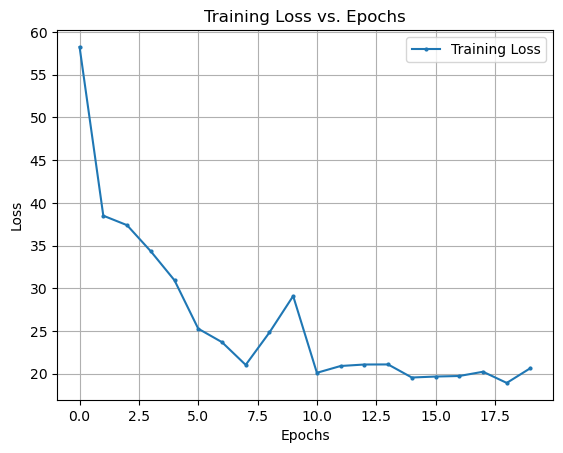

In [21]:
training_losses = [
    58.2576, 38.4971, 37.3844, 34.3301, 30.9300, 25.2657, 23.6881, 21.0240, 24.8198, 29.0908,
    20.0993, 20.8967, 21.0701, 21.0791, 19.5483, 19.6611, 19.7255, 20.2223, 18.9144, 20.6481
]

epochs_plot = list(range(0,num_epochs))

# Plot training losses against epochs
plt.plot(epochs_plot, training_losses, marker='o', markersize=2, label='Training Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Testing NN

In [15]:
# Assuming you have a test dataset similar to your training dataset
test_dataset = TensorDataset(testing_NN_inputs)  # Replace with your actual test tensor data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set shuffle=False for testing

In [16]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:

            # Question: Should I take out the targets' squeeze and unsqueeze here?
            inputs = inputs.squeeze(0).permute(2, 0, 1).float()  # Prepare input shape
            targets = targets.squeeze(0).float()  # Prepare target shape

            # Forward pass
            outputs = model(inputs.unsqueeze(0))  # Add batch dimension
            targets = targets.unsqueeze(0)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Accumulate loss
            total_loss += loss.item()

            # Store predictions and targets
            all_predictions.append(outputs.cpu())  # Store outputs directly
            all_targets.append(targets.cpu())  # Store targets directly

    average_loss = total_loss / len(test_loader)

    # Convert lists to tensors
    all_predictions = torch.cat(all_predictions, dim=0)  # Concatenate along the batch dimension
    all_targets = torch.cat(all_targets, dim=0)  # Concatenate along the batch dimension

    return average_loss, all_predictions, all_targets


In [17]:
# Define your criterion (loss function)
criterion = nn.MSELoss()  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

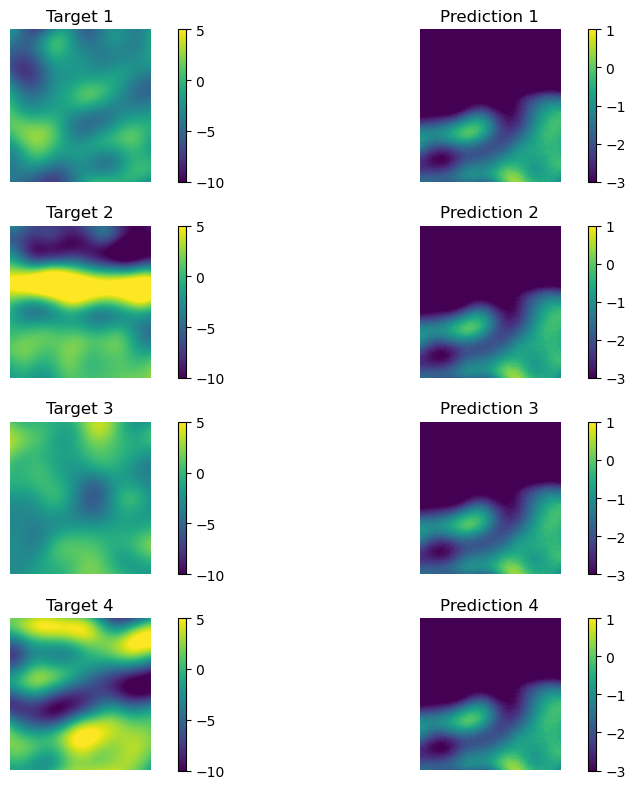

In [18]:
def plot_predictions_vs_targets(predictions, targets, num_samples=4):
    # Ensure we're only plotting a limited number of samples
    num_samples = min(num_samples, predictions.shape[0])

    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))

    for i in range(num_samples):
        # Plot the target image
        ax = axes[i, 0]
        target_image = targets[i]
        
        # Check the number of dimensions and reshape if necessary
        if target_image.dim() == 3:
            img = ax.imshow(target_image.permute(1, 2, 0).cpu().numpy(), vmin=-10, vmax=5)  # (C, H, W) to (H, W, C)
        elif target_image.dim() == 2:
            img = ax.imshow(target_image.cpu().numpy(), vmin=-10, vmax=5)  # Single channel image
        ax.set_title(f'Target {i + 1}')
        ax.axis('off')

        # Add colorbar for the target image
        fig.colorbar(img, ax=ax)

        # Plot the predicted image
        ax = axes[i, 1]
        prediction_image = predictions[i]
        
        # Check the number of dimensions and reshape if necessary
        if prediction_image.dim() == 3:
            img = ax.imshow(prediction_image.permute(1, 2, 0).cpu().numpy(), vmin=-3, vmax=1)  # (C, H, W) to (H, W, C)
        elif prediction_image.dim() == 2:
            img = ax.imshow(prediction_image.cpu().numpy(), vmin=-3, vmax=1)  # Single channel image
        ax.set_title(f'Prediction {i + 1}')
        ax.axis('off')

        # Add colorbar for the predicted image
        fig.colorbar(img, ax=ax)

    plt.tight_layout()
    plt.show()


# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=4)  # Change num_samples as needed


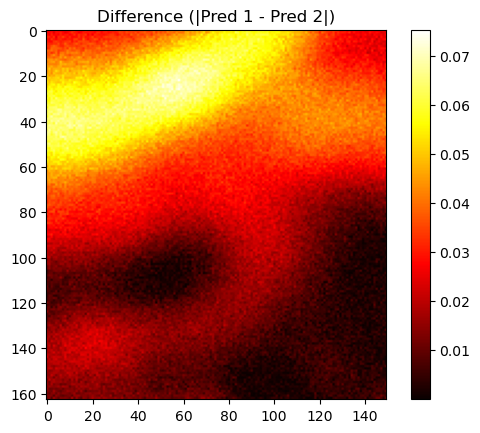

In [19]:
# Assuming predictions are stored as predictions (e.g., output of the evaluate_model function)
# and that they're of shape (num_samples, height, width)

# Select two predictions to compare, for example the first and the second
pred_1 = predictions[0].squeeze().cpu().numpy()  # Convert to numpy for plotting
pred_2 = predictions[1].squeeze().cpu().numpy()

difference = np.abs(pred_1 - pred_2)

# Plot the difference with a color bar
difference_plot = plt.imshow(difference, cmap='hot')  # Use a heatmap to emphasize differences
plt.title('Difference (|Pred 1 - Pred 2|)')
plt.colorbar(difference_plot) 

plt.show()


In [20]:
mse = np.mean((pred_1 - pred_2) ** 2)
print(f"Mean Squared Error between Prediction 1 and 2: {mse:.6f}")

Mean Squared Error between Prediction 1 and 2: 0.001062


# What if num_epochs = 100?

## Training

In [ ]:
num_epochs = 100  # Number of epochs to train

In [ ]:
# Training loop

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in train_loader:
        # inputs shape: [1, y, x, variables (6)]
        # targets shape: [1, y, x]

        # Note: Squeeze and unsqueeze to make model more generalizable (can skip if dims are exact)
        
        # Squeeze batch dimension (since batch_size=1)
        inputs = inputs.squeeze(0).permute(2, 0, 1)  # Reshape to (vars, y, x) --> CNN input expects vars/channels first 
        targets = targets.squeeze(0)  # Shape: (y, x)

        # Convert inputs to float32
        inputs = inputs.float()
        targets = targets.float()

        # Zero/reset the parameter gradients before next iteration
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension back for CNN (shape: [1, vars, y, x])
        targets = targets.unsqueeze(0)  # Add batch dimension to targets

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

print("Training complete!")

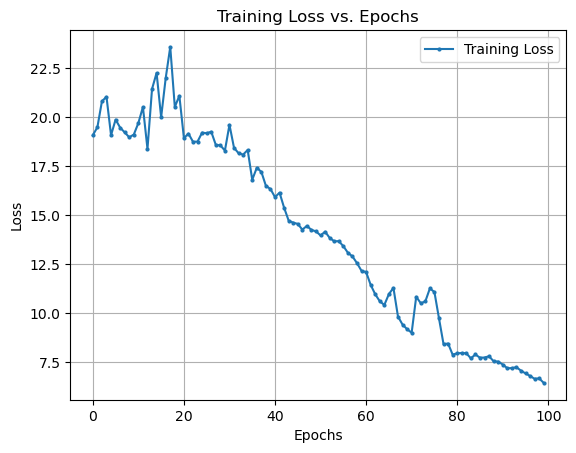

In [24]:
training_losses = [
    19.0773, 19.4775, 20.8020, 21.0310, 19.0767, 19.8689, 19.4604, 19.2167, 18.9690, 19.1084,
    19.6941, 20.5108, 18.3785, 21.4297, 22.2464, 19.9881, 21.9821, 23.5706, 20.5160, 21.0812,
    18.9271, 19.1566, 18.7368, 18.7526, 19.2070, 19.1739, 19.2510, 18.5835, 18.5587, 18.2912,
    19.6051, 18.4310, 18.1576, 18.0870, 18.3203, 16.8051, 17.4140, 17.2090, 16.4970, 16.3327,
    15.9212, 16.1473, 15.3785, 14.7220, 14.6192, 14.5572, 14.2650, 14.4554, 14.2505, 14.1771,
    13.9695, 14.1602, 13.8456, 13.6713, 13.6787, 13.4235, 13.0896, 12.9002, 12.5600, 12.1646,
    12.1065, 11.4535, 10.9740, 10.6179, 10.4280, 10.9790, 11.2999, 9.8377, 9.4294, 9.1953,
    9.0132, 10.8460, 10.5179, 10.6066, 11.2696, 11.0874, 9.7497, 8.4329, 8.4639, 7.8986,
    7.9663, 7.9819, 7.9684, 7.7110, 7.9055, 7.7403, 7.7519, 7.8149, 7.5592, 7.5461,
    7.3947, 7.2073, 7.2116, 7.2580, 7.0829, 6.9428, 6.8130, 6.6663, 6.6899, 6.4574
]

epochs_plot = list(range(0,num_epochs))

# Plot training losses against epochs
plt.plot(epochs_plot, training_losses, marker='o', markersize=2, label='Training Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

### Testing

In [25]:
# Assuming you have a test dataset similar to your training dataset
test_dataset = TensorDataset(testing_NN_inputs)  # Replace with your actual test tensor data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set shuffle=False for testing

In [26]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:

            # Question: Should I take out the targets' squeeze and unsqueeze here?
            inputs = inputs.squeeze(0).permute(2, 0, 1).float()  # Prepare input shape
            targets = targets.squeeze(0).float()  # Prepare target shape

            # Forward pass
            outputs = model(inputs.unsqueeze(0))  # Add batch dimension
            targets = targets.unsqueeze(0)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Accumulate loss
            total_loss += loss.item()

            # Store predictions and targets
            all_predictions.append(outputs.cpu())  # Store outputs directly
            all_targets.append(targets.cpu())  # Store targets directly

    average_loss = total_loss / len(test_loader)

    # Convert lists to tensors
    all_predictions = torch.cat(all_predictions, dim=0)  # Concatenate along the batch dimension
    all_targets = torch.cat(all_targets, dim=0)  # Concatenate along the batch dimension

    return average_loss, all_predictions, all_targets


In [27]:
# Define your criterion (loss function)
criterion = nn.MSELoss()  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

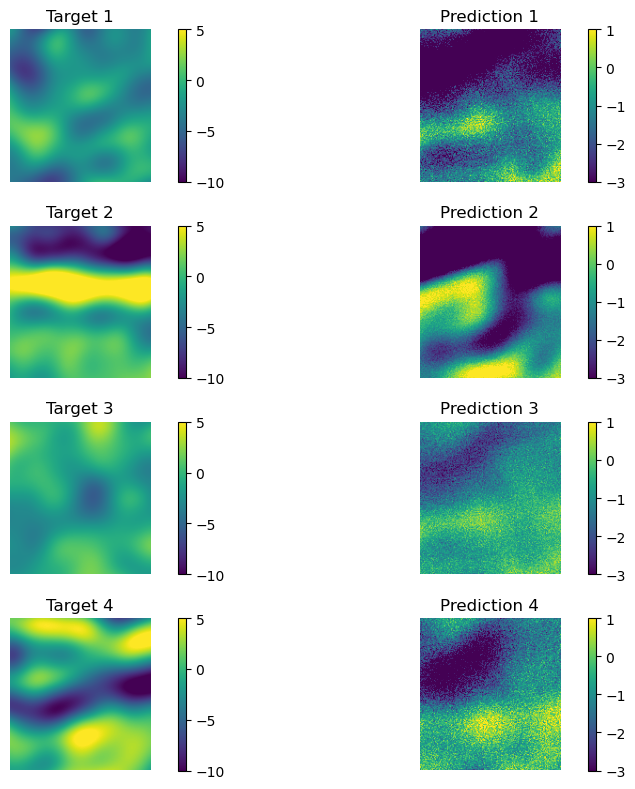

In [28]:
def plot_predictions_vs_targets(predictions, targets, num_samples=4):
    # Ensure we're only plotting a limited number of samples
    num_samples = min(num_samples, predictions.shape[0])

    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))

    for i in range(num_samples):
        # Plot the target image
        ax = axes[i, 0]
        target_image = targets[i]
        
        # Check the number of dimensions and reshape if necessary
        if target_image.dim() == 3:
            img = ax.imshow(target_image.permute(1, 2, 0).cpu().numpy(), vmin=-10, vmax=5)  # (C, H, W) to (H, W, C)
        elif target_image.dim() == 2:
            img = ax.imshow(target_image.cpu().numpy(), vmin=-10, vmax=5)  # Single channel image
        ax.set_title(f'Target {i + 1}')
        ax.axis('off')

        # Add colorbar for the target image
        fig.colorbar(img, ax=ax)

        # Plot the predicted image
        ax = axes[i, 1]
        prediction_image = predictions[i]
        
        # Check the number of dimensions and reshape if necessary
        if prediction_image.dim() == 3:
            img = ax.imshow(prediction_image.permute(1, 2, 0).cpu().numpy(), vmin=-3, vmax=1)  # (C, H, W) to (H, W, C)
        elif prediction_image.dim() == 2:
            img = ax.imshow(prediction_image.cpu().numpy(), vmin=-3, vmax=1)  # Single channel image
        ax.set_title(f'Prediction {i + 1}')
        ax.axis('off')

        # Add colorbar for the predicted image
        fig.colorbar(img, ax=ax)

    plt.tight_layout()
    plt.show()


# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=4)  # Change num_samples as needed


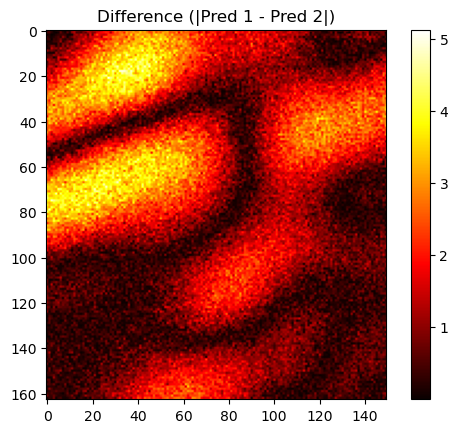

In [29]:
# Assuming predictions are stored as predictions (e.g., output of the evaluate_model function)
# and that they're of shape (num_samples, height, width)

# Select two predictions to compare, for example the first and the second
pred_1 = predictions[0].squeeze().cpu().numpy()  # Convert to numpy for plotting
pred_2 = predictions[1].squeeze().cpu().numpy()

difference = np.abs(pred_1 - pred_2)

# Plot the difference with a color bar
difference_plot = plt.imshow(difference, cmap='hot')  # Use a heatmap to emphasize differences
plt.title('Difference (|Pred 1 - Pred 2|)')
plt.colorbar(difference_plot) 

plt.show()


In [30]:
mse = np.mean((pred_1 - pred_2) ** 2)
print(f"Mean Squared Error between Prediction 1 and 2: {mse:.6f}")

Mean Squared Error between Prediction 1 and 2: 3.011111


# What if num_epochs = 1000?

In [14]:
num_epochs = 1000  # Number of epochs to train
loss_values = []

# Training loop

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, targets in train_loader:
        # inputs shape: [1, y, x, variables (6)]
        # targets shape: [1, y, x]

        # Note: Squeeze and unsqueeze to make model more generalizable (can skip if dims are exact)
        
        # Squeeze batch dimension (since batch_size=1)
        inputs = inputs.squeeze(0).permute(2, 0, 1)  # Reshape to (vars, y, x) --> CNN input expects vars/channels first 
        targets = targets.squeeze(0)  # Shape: (y, x)

        # Convert inputs to float32
        inputs = inputs.float()
        targets = targets.float()

        # Zero/reset the parameter gradients before next iteration
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension back for CNN (shape: [1, vars, y, x])
        targets = targets.unsqueeze(0)  # Add batch dimension to targets

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # Accumulate running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = running_loss / len(train_loader)
    
    # Store average loss in the list
    loss_values.append(average_loss)
    
    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}")

print("Training complete!")

Epoch [1/1000], Loss: 2.5308
Epoch [2/1000], Loss: 2.3447
Epoch [3/1000], Loss: 2.4350
Epoch [4/1000], Loss: 2.3511
Epoch [5/1000], Loss: 2.4211
Epoch [6/1000], Loss: 2.3447
Epoch [7/1000], Loss: 2.3375
Epoch [8/1000], Loss: 2.2940
Epoch [9/1000], Loss: 2.2748
Epoch [10/1000], Loss: 2.2849
Epoch [11/1000], Loss: 2.3252
Epoch [12/1000], Loss: 2.3030
Epoch [13/1000], Loss: 2.3018
Epoch [14/1000], Loss: 2.3777
Epoch [15/1000], Loss: 2.4065
Epoch [16/1000], Loss: 2.4522
Epoch [17/1000], Loss: 2.3189
Epoch [18/1000], Loss: 2.4760
Epoch [19/1000], Loss: 2.4083
Epoch [20/1000], Loss: 2.4291
Epoch [21/1000], Loss: 2.5021
Epoch [22/1000], Loss: 2.7920
Epoch [23/1000], Loss: 2.7713
Epoch [24/1000], Loss: 2.8268
Epoch [25/1000], Loss: 2.9241
Epoch [26/1000], Loss: 2.8648
Epoch [27/1000], Loss: 3.4379
Epoch [28/1000], Loss: 2.9673
Epoch [29/1000], Loss: 2.7847
Epoch [30/1000], Loss: 2.9609
Epoch [31/1000], Loss: 2.6201
Epoch [32/1000], Loss: 2.3730
Epoch [33/1000], Loss: 2.2900
Epoch [34/1000], Lo

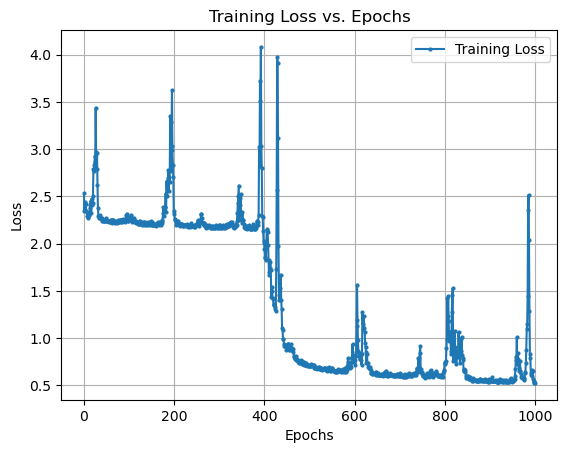

In [15]:
epochs_plot = list(range(0,num_epochs))

# Plot training losses against epochs
plt.plot(epochs_plot, loss_values, marker='o', markersize=2, label='Training Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

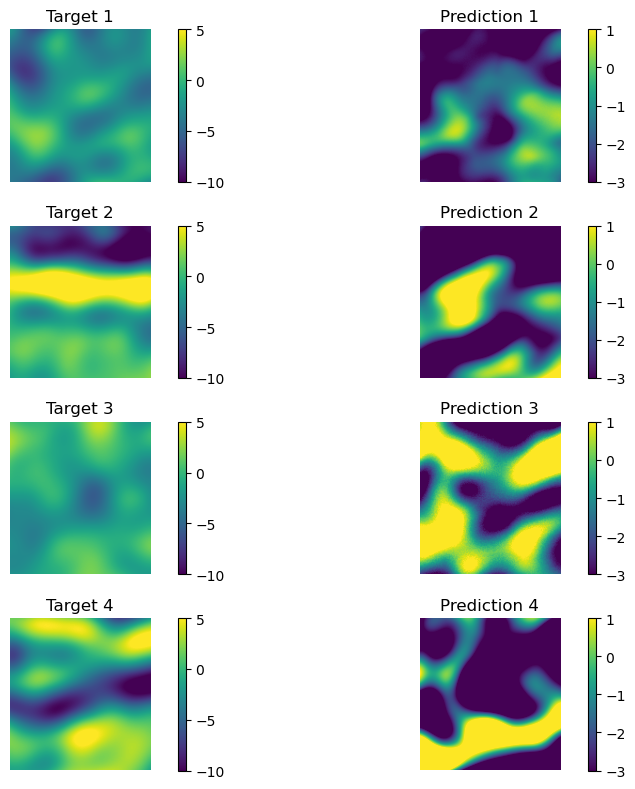

In [16]:
# Assuming you have a test dataset similar to your training dataset
test_dataset = TensorDataset(testing_NN_inputs)  # Replace with your actual test tensor data
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Set shuffle=False for testing

def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:

            # Question: Should I take out the targets' squeeze and unsqueeze here?
            inputs = inputs.squeeze(0).permute(2, 0, 1).float()  # Prepare input shape
            targets = targets.squeeze(0).float()  # Prepare target shape

            # Forward pass
            outputs = model(inputs.unsqueeze(0))  # Add batch dimension
            targets = targets.unsqueeze(0)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Accumulate loss
            total_loss += loss.item()

            # Store predictions and targets
            all_predictions.append(outputs.cpu())  # Store outputs directly
            all_targets.append(targets.cpu())  # Store targets directly

    average_loss = total_loss / len(test_loader)

    # Convert lists to tensors
    all_predictions = torch.cat(all_predictions, dim=0)  # Concatenate along the batch dimension
    all_targets = torch.cat(all_targets, dim=0)  # Concatenate along the batch dimension

    return average_loss, all_predictions, all_targets


# Define your criterion (loss function)
criterion = nn.MSELoss()  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

def plot_predictions_vs_targets(predictions, targets, num_samples=4):
    # Ensure we're only plotting a limited number of samples
    num_samples = min(num_samples, predictions.shape[0])

    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))

    for i in range(num_samples):
        # Plot the target image
        ax = axes[i, 0]
        target_image = targets[i]
        
        # Check the number of dimensions and reshape if necessary
        if target_image.dim() == 3:
            img = ax.imshow(target_image.permute(1, 2, 0).cpu().numpy(), vmin=-10, vmax=5)  # (C, H, W) to (H, W, C)
        elif target_image.dim() == 2:
            img = ax.imshow(target_image.cpu().numpy(), vmin=-10, vmax=5)  # Single channel image
        ax.set_title(f'Target {i + 1}')
        ax.axis('off')

        # Add colorbar for the target image
        fig.colorbar(img, ax=ax)

        # Plot the predicted image
        ax = axes[i, 1]
        prediction_image = predictions[i]
        
        # Check the number of dimensions and reshape if necessary
        if prediction_image.dim() == 3:
            img = ax.imshow(prediction_image.permute(1, 2, 0).cpu().numpy(), vmin=-3, vmax=1)  # (C, H, W) to (H, W, C)
        elif prediction_image.dim() == 2:
            img = ax.imshow(prediction_image.cpu().numpy(), vmin=-3, vmax=1)  # Single channel image
        ax.set_title(f'Prediction {i + 1}')
        ax.axis('off')

        # Add colorbar for the predicted image
        fig.colorbar(img, ax=ax)

    plt.tight_layout()
    plt.show()


# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=4)  # Change num_samples as needed

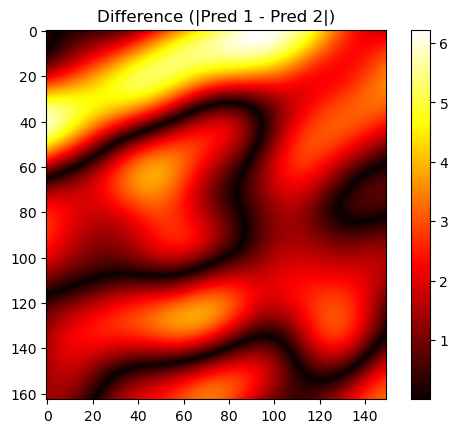

In [17]:
# Assuming predictions are stored as predictions (e.g., output of the evaluate_model function)
# and that they're of shape (num_samples, height, width)

# Select two predictions to compare, for example the first and the second
pred_1 = predictions[0].squeeze().cpu().numpy()  # Convert to numpy for plotting
pred_2 = predictions[1].squeeze().cpu().numpy()

difference = np.abs(pred_1 - pred_2)

# Plot the difference with a color bar
difference_plot = plt.imshow(difference, cmap='hot')  # Use a heatmap to emphasize differences
plt.title('Difference (|Pred 1 - Pred 2|)')
plt.colorbar(difference_plot) 

plt.show()


In [18]:
mse = np.mean((pred_1 - pred_2) ** 2)
print(f"Mean Squared Error between Prediction 1 and 2: {mse:.6f}")

Mean Squared Error between Prediction 1 and 2: 5.916960
